In [13]:
import sys
import os

sys.path.append('/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/training')

In [14]:
from tl_tools import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np 
setup_mixed_precision()

Mixed precision policy set to: mixed_float16



In [15]:
resnet50v1_path = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/trained_models/resnet_50v1.keras'
resnet50 = load_model(resnet50v1_path)

In [16]:
test_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/USTC_SmokeRS/processed/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(test_dir, color_mode= 'rgb', batch_size = 16, shuffle= False, seed = 1, target_size=(256, 256))
X_test, y_test = test_splits(test)

class_labels = list(test.class_indices.keys())

Found 1245 images belonging to 6 classes.
Number of batches in the test data: 78
Batch size of a single batch 16
Number of samples in the test dataset 1245

Shape of image test set: (1245, 256, 256, 3)

Shape of label test set: (1245, 6)


In [17]:
feature_extractor = Model(inputs=resnet50.input, outputs=resnet50.get_layer('avg_pool').output)
feature_extractor_pred = feature_extractor.predict(X_test)

y_true = tf.argmax(y_test, axis=1).numpy()

39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 610ms/step


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feature_extractor_pred = scaler.fit_transform(feature_extractor_pred)
feature_extractor_df = pd.DataFrame(feature_extractor_pred)
y_true_series = pd.Series(y_true)

class_mapping = dict()
for i, label in enumerate(class_labels): 
    class_mapping[i] = label

y_true_labels = y_true_series.map(class_mapping)


In [19]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(feature_extractor_df, y_true_series)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [20]:
feature_importances = pd.Series(xgb.feature_importances_).sort_values(ascending= False)
n_features = len(feature_importances)
print(f'Number of features: {n_features:,}')

percentage_5 = feature_importances.head((n_features // 20)).sum()
percentage_10 = feature_importances.head((n_features // 10)).sum()
percentage_25 = feature_importances.head((n_features // 4)).sum()

print(f'Cumulative feature importance of 5% of the extracted features: {(percentage_5 * 100):.2f}%')
print(f'Cumulative feature importance of 10% of the extracted features: {(percentage_10 * 100):.2f}%')
print(f'Cumulative feature importance of 25% of the extracted features: {(percentage_25 * 100):.2f}%')

Number of features: 2,048
Cumulative feature importance of 5% of the extracted features: 69.26%
Cumulative feature importance of 10% of the extracted features: 80.95%
Cumulative feature importance of 25% of the extracted features: 95.05%


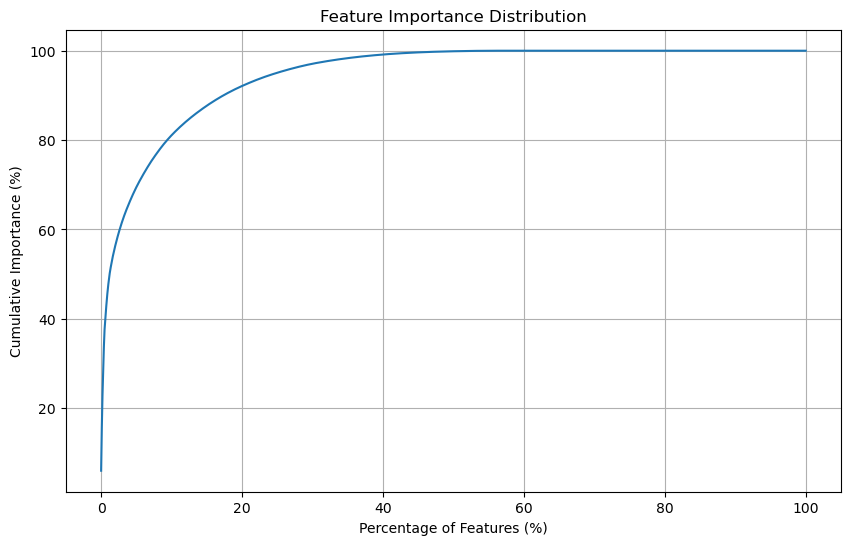

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

x_normalized = np.linspace(0, 100, len(feature_importances))
plt.plot(x_normalized, feature_importances.cumsum() * 100)
plt.xlabel('Percentage of Features (%)')
plt.ylabel('Cumulative Importance (%)')
plt.title('Feature Importance Distribution')
plt.grid(True)

In [22]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state= 1, perplexity= 30, max_iter = 2000, learning_rate= 'auto', init = 'pca')
X_tsne = tsne.fit_transform(feature_extractor_df)
tsne_df = pd.DataFrame(data = {
    'x1': X_tsne[:, 0], 
    'x2': X_tsne[:, 1], 
    'class': y_true_series
})

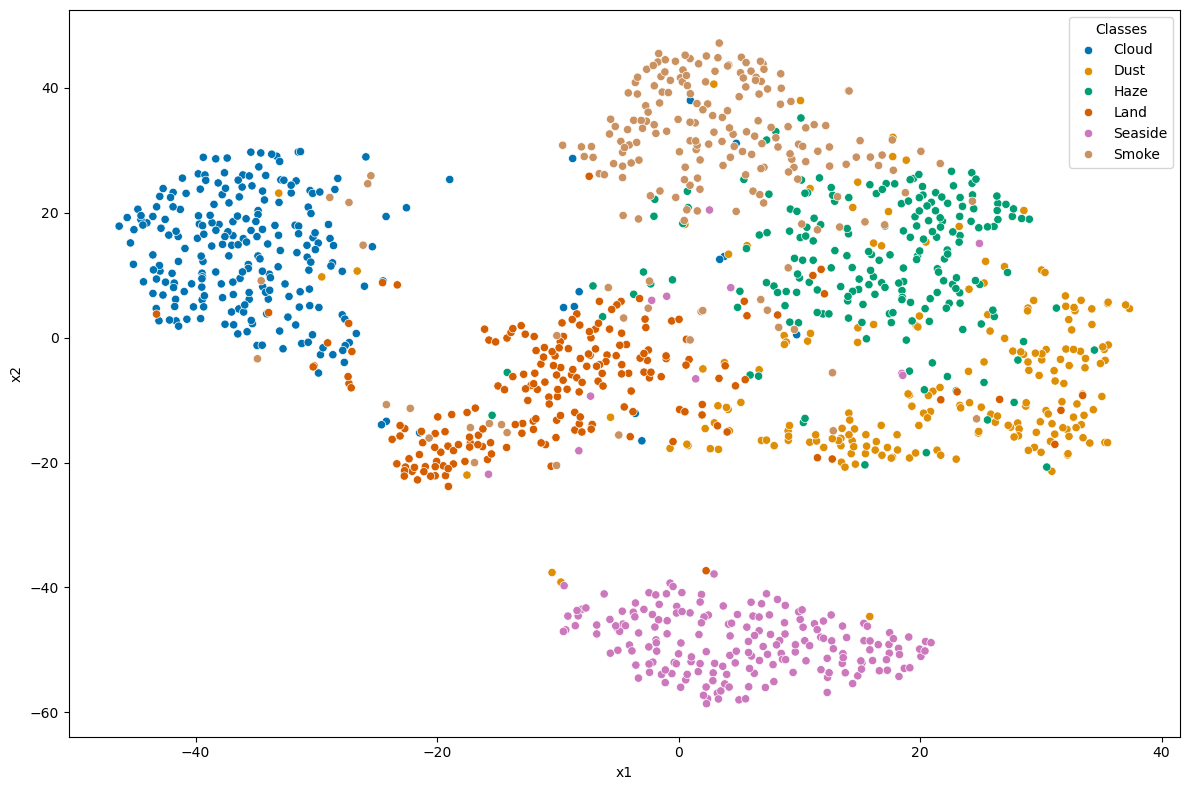

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize= (12, 8))
scatter = sns.scatterplot(x = 'x1', y = 'x2', data = tsne_df, hue = y_true_labels, palette = 'colorblind')
scatter.legend(title = 'Classes')
plt.tight_layout()
plt.show()

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

features = tsne_df[['x1','x2']]

silhouette_scores = list()
davies_scores = list()

for n in range(10): 
    kmeans = KMeans(n_clusters=6, max_iter=1500, random_state= n, n_init = 10)
    cluster_labels = kmeans.fit_predict(features)

    silhouette_scores.append(silhouette_score(features, cluster_labels))
    davies_scores.append(davies_bouldin_score(features, cluster_labels))

silhouette_mean = np.mean(silhouette_scores)
silhouette_std = np.std(silhouette_scores)
davies_mean = np.mean(davies_scores)
davies_std = np.std(davies_scores)

print(f'Mean Silhouette Score: {silhouette_mean:.2f} (± {silhouette_std:.2f})')
print(f'Mean Davies-Boulding Score: {davies_mean:.2f} (± {davies_std:.2f})')

Mean Silhouette Score: 0.53 (± 0.00)
Mean Davies-Boulding Score: 0.64 (± 0.00)
